Stationary stochastic processes,<br>
Lund University, <br>
Centre for Mathematical Sciences HT 2024, <br>
Mathematical Statistics

# Computer exercise 3 (Ladok-Lab 2b)

In this computer exercise you will investigate the concepts of leakage, resolution and variance for different periodogram-based spectral estimation techniques. You will also study the importance of using zero-mean data and zero-padding, exemplified in the estimation of sunspot data periodicity. Finally, you will compute and investigate coherence of multi-channel electrical signals measured from the brain during a flickering light experiment.
***
* Please work in groups of two students!
***

In [3]:
!wget https://raw.githubusercontent.com/axellangenskiold/fmsf10/refs/heads/main/help_funcs_SSP.py
!wget -q https://raw.githubusercontent.com/axellangenskiold/fmsf10/refs/heads/main/sunspotdata.mat
!wget -q https://raw.githubusercontent.com/axellangenskiold/fmsf10/refs/heads/main/eegsingle.mat
!wget -q https://raw.githubusercontent.com/axellangenskiold/fmsf10/refs/heads/main/eegmulti.mat

--2025-10-09 11:19:23--  https://raw.githubusercontent.com/axellangenskiold/fmsf10/refs/heads/main/help_funcs_SSP.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7166 (7.0K) [text/plain]
Saving to: ‘help_funcs_SSP.py’

help_funcs_SSP.py   100%[===================>]   7.00K  --.-KB/s    in 0s      

2025-10-09 11:19:23 (26.8 MB/s) - ‘help_funcs_SSP.py’ saved [7166/7166]



In [4]:
# Imports
import numpy as np
import scipy.signal
import scipy.io as sio
from scipy.fft import fft, ifft
from matplotlib import pyplot as plt

from help_funcs_SSP import calculate_pmtm

# Data loading for the exercise
path_to_data = "sunspotdata.mat" # Change to YOUR path to data.
mat = sio.loadmat(path_to_data,simplify_cells=True)
dataold = mat["dataold"]
datanew = mat["datanew"]
timeold = mat["timeold"]
timenew = mat["timenew"]
path_to_data = "eegsingle.mat" # Change to YOUR path to data.
mat = sio.loadmat(path_to_data,simplify_cells=True)
eegsingle = mat["eeg"]
time_single = mat["time"]
path_to_data = "eegmulti.mat" # Change to YOUR path to data.
mat = sio.loadmat(path_to_data,simplify_cells=True)
eegmulti = mat["eegmat"]
time_multi = mat["time"]
channels = mat["channels"]

## 1 Investigation of spectral estimation techniques for simulated data

The commonly applied periodogram-based spectral estimation techniques have different advantages and drawbacks which are important to recognize. The spectral estimate from a specific technique could be a powerful tool for showing properties of data but could also be completely useless as the method might hide important information. We will compare the spectral estimates of the most commonly applied techniques for sequences of simulated data from an ARMA-process.   

### 1.1 Leakage comparison of periodogram-based methods

Simulate a 500 sample realization of an ARMA(4,2)-process

In [33]:
A = [1, -2.39, 3.35, -2.34, 0.96]
C = [1, 0, 0.999]

e = np.random.randn(1000,1)
x = scipy.signal.lfilter(C, A, e,axis=0)
x = x[500:]
e = e[500:]

e2 = np.random.randn(1000, 1)
x2 = scipy.signal.lfilter(C, A, e2, axis=0)
x2 = x2[500:]
e2 = e2[500:]

We assume that the realization `x` is sampled with $f_s=100$ Hz. Create the corresponding timescale `tvect` and plot the data,

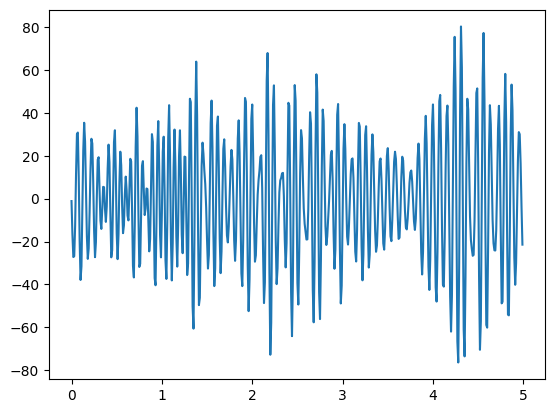

In [27]:
# Write your own code below
fs = 100  # Hz
Ts = 1/fs

N = len(x)
tvect = np.arange(N) * Ts


# Plotting
plt.plot(tvect,x);

Estimate and plot the spectral density in dB-scale using the periodogram function, with zero-padding up to FFT-length `nfft=4096`, using `scipy.signal.periodogram(x,fs=?,nfft=?,axis=0)`

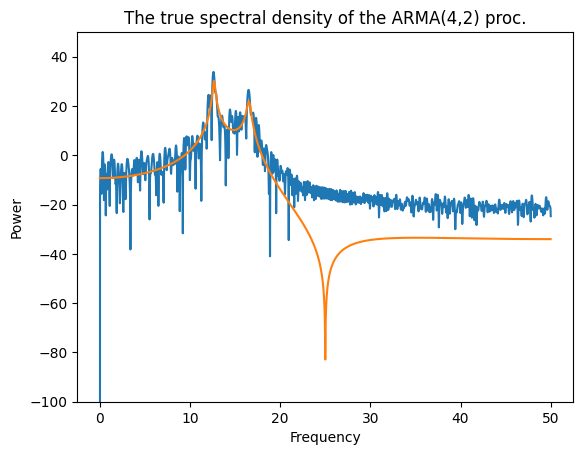

<Figure size 640x480 with 0 Axes>

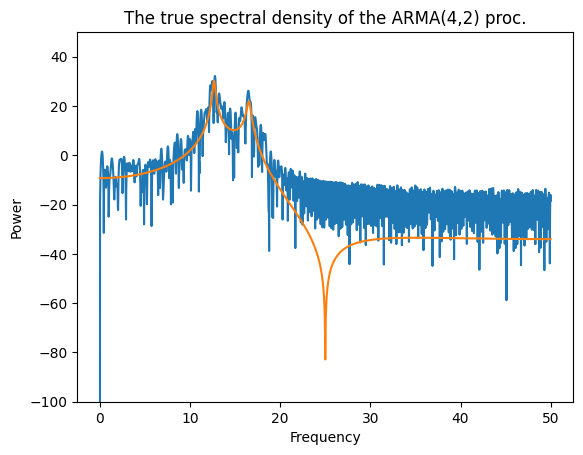

<Figure size 640x480 with 0 Axes>

In [34]:
# Write your own code below

fs = 100
nfft = 4096

f, p = scipy.signal.periodogram(x, fs=fs, nfft=nfft, axis=0)

p_db = 10 * np.log10(p)

plt.plot(f, p_db)
# The true spectrum of the process
w,h = scipy.signal.freqz(C,A,worN=4096)
R = np.abs(h)**2
plt.plot(w/2/np.pi*fs,10*np.log10(R/fs))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.ylim([-100,50])
plt.title("The true spectral density of the ARMA(4,2) proc.");
plt.show()

f, p = scipy.signal.periodogram(x2, fs=fs, nfft=nfft, axis=0)

p_db = 10 * np.log10(p)

plt.plot(f, p_db)
# The true spectrum of the process
w,h = scipy.signal.freqz(C,A,worN=4096)
R = np.abs(h)**2
plt.plot(w/2/np.pi*fs,10*np.log10(R/fs))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.ylim([-100,50])
plt.title("The true spectral density of the ARMA(4,2) proc.");
plt.figure()


Compare your periodogram estimate to the true spectral density and verify that the peaks of your estimate are at the correct frequency locations. Run the above commands again, starting with the simulation of a new noise sequence `e` to receive a new realization `x`. Plot the corresponding periodogram together with the previous one or in another figure. Compare the two periodograms with the true spectral density.

***Q1. For which frequency band do you find the bias to be large independently of the realization you analyse? Explain why the bias is large in this specific frequency band.***

***A1***. The bias appear to be for 25 Hz. This happens because the periodogram smears/leaks energy "into" 25Hz from nearby frequencies.

<br></br>

For a decrease in the bias, the spectral leakage needs to be reduced. Compute and plot a spectral estimate using a Hanning windowed, (modified) periodogram,
`scipy.signal.periodogram(x,fs=?,nfft=?,axis=0,window='hann')`. Repeat the modified periodogram calculation above for a new realization `x` and plot the resulting spectral estimate. Note that the variance between estimates of different realizations still is large.

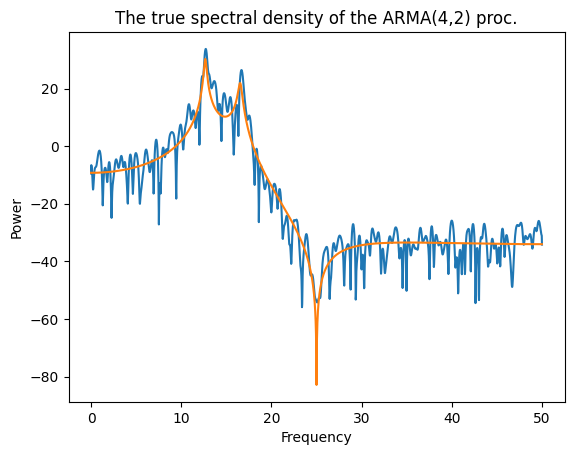

In [38]:
# Write your own code below:
e = np.random.randn(1000,1)
x = scipy.signal.lfilter(C, A, e,axis=0)
x = x[500:]
e = e[500:]

f, p = scipy.signal.periodogram(x,fs=fs,nfft=nfft,axis=0,window='hann')

plt.plot(f, 10 * np.log10(p))


# The true spectrum of the process
w,h = scipy.signal.freqz(C,A,worN=4096)
R = np.abs(h)**2
plt.plot(w/2/np.pi*fs,10*np.log10(R/fs))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("The true spectral density of the ARMA(4,2) proc.");

***Q2. Explain, by referring to height of window sidelobes and comparing to the sidelobes of the ordinary periodogram (see course book page 248), why the bias is reduced in the modified periodogram?***'

***A2***.

- The normal periodogram has very tall sidelobes, which means that energy from strong frequency components leaks into nearby frequencies.

- When we multiply the data with the Hann window, the sidelobes gets smaller. This results in smaller leakage into neighbour frequencies when when we compute strong frequencies.

<br></br>

### 1.2 The balance between resolution and variance reduction of periodogram-based methods

The variance between the spectral estimates of different realizations of a process is large for both the periodogram and the modified periodogram. The variance can be reduced if the available data sequence is split into several shorter sequences. From each sequence a modified periodogram is computed and finally all the periodograms are averaged. The method is referred to as the Welch method. Apply the Welch method with $10$ time-shifted Hanning windows and 50\% overlap  for the above ARMA-process with 500 samples. Compute the resulting window length `L` of the time-shifted Hanning window.

In [44]:
# len(x) = (10 - 1)*L/2 + L
# len(x) = (11/2)*L
L = len(x)*(2/11)
L

90.9090909090909

***Q3. What is the resulting value of `L`?***

***A3***. L = 90.9

Use your calculated value of `L`  as input variable to the function `scipy.signal.welch()`, where `L/2` as the `noverlap` variable will result in 50\% overlap. Apply the Welch method to a few different realizations of your ARMA-process, and compare the view  of the different spectral estimates.

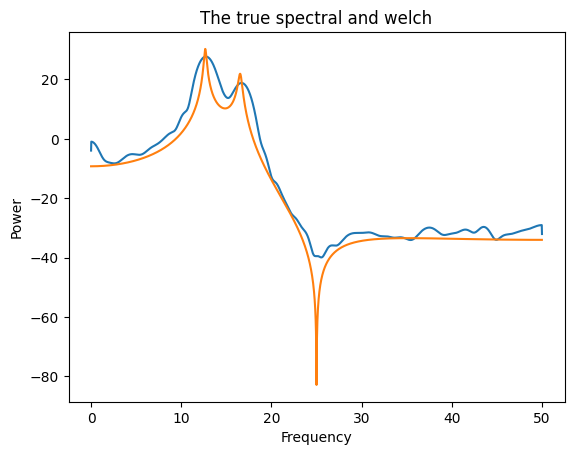

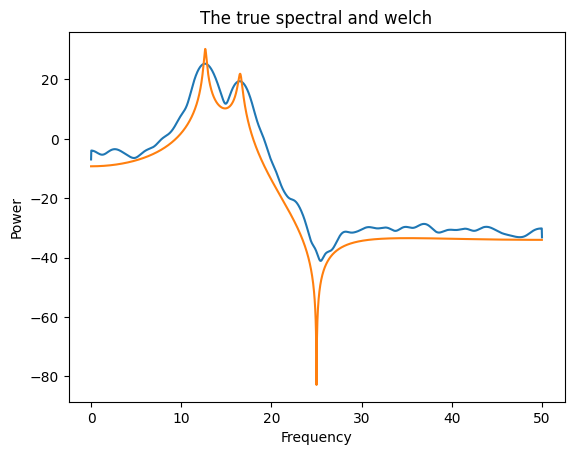

In [50]:
# Write your own code below


# Estimate with Welch method
f, P = scipy.signal.welch(x, fs=fs, nfft=nfft, window='hann', nperseg=L,noverlap=L/2,axis=0)
plt.plot(f,10*np.log10(P))
# The true spectrum of the process
w,h = scipy.signal.freqz(C,A,worN=4096)
R = np.abs(h)**2
plt.plot(w/2/np.pi*fs,10*np.log10(R/fs))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("The true spectral and welch");
plt.show()

f, P = scipy.signal.welch(x2, fs=fs, nfft=nfft, window='hann', nperseg=L,noverlap=L/2,axis=0)
plt.plot(f,10*np.log10(P))
# The true spectrum of the process
w,h = scipy.signal.freqz(C,A,worN=4096)
R = np.abs(h)**2
plt.plot(w/2/np.pi*fs,10*np.log10(R/fs))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("The true spectral and welch");
plt.show()

***Q4. How can you see that the variance  is reduced for the Welch method in comparison to the variance of the modified periodogram?***

***A4***.

- The curve for the welch method is a lot smoother and less jagged.
<br></br>
The gain in reduced variance comes with a decrease in resolution.  
<br></br>
***Q5. In what part of the spectral estimate from the Welch method  is the decreased resolution most clearly seen? Explain the decreased resolution by referring to window length and corresponding mainlobe width of the Hanning window (see course book page 248-249).***

***A5***.

- It's most clearly seen in the peaks. The peaks gets wider and looks smeared out.

- The resolution is dependant on the width of the main lobe. When we decrease the window length with the welch method, we increases the width of main lobe, and hence the resolution decreases.

<br></br>


### 1.3 Comparison of variances for different methods
A simple comparison of the variances for different methods  can be made from a white noise sequence, e.g. the previously computed input sequence `e`. As the spectral density of a white noise sequence should be a constant level, with all values corresponding to the variance of the noise, we can calculate the variance of this level  from a single spectral estimate and compare different methods. Compare the modified periodogram and the Welch method estimated as

    scipy.signal.periodogram(e,fs=fs,nfft=nfft,axis=0,window='hann')
    scipy.signal.welch(e, fs=fs, nfft=nfft, window='hann', nperseg=L,noverlap=L/2,axis=0)

Plot the resulting spectral estimates and compute the variances of `Rhate` and `Rhatew` respectively, and the ratio of them, i.e.,
`np.var(Rhate)/np.var(Rhatew)`. Repeat this a few times for new simulations of the white noise sequence.

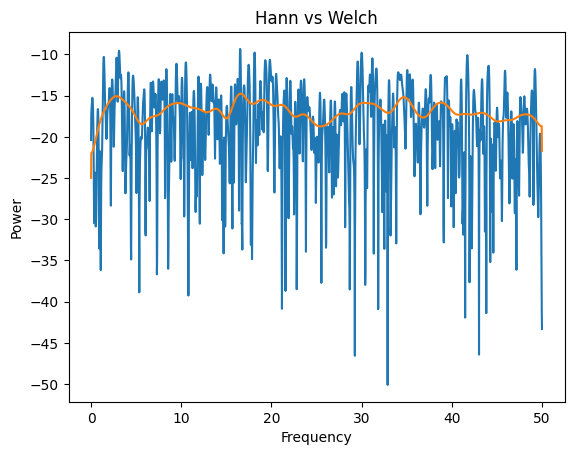

0.00040717275708231554
2.270654631333769e-05
17.93195457660352
19.764511049547476


In [82]:
# Write your own code below
f_hann, p_hann = scipy.signal.periodogram(e,fs=fs,nfft=nfft,axis=0,window='hann')
f_welch, p_welch = scipy.signal.welch(e, fs=fs, nfft=nfft, window='hann', nperseg=L,noverlap=L/2,axis=0)

plt.plot(f_hann, 10 * np.log10(p_hann))
plt.plot(f_welch, 10 * np.log10(p_welch))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Hann vs Welch");
plt.show()

Rhate = p_hann
Rhatew = p_welch

print(np.var(Rhate))
print(np.var(Rhatew))
print(np.var(Rhate)/np.var(Rhatew))

mean = []
for i in range(1000):
  e = np.random.randn(1000,1)
  f_hann, p_hann = scipy.signal.periodogram(e,fs=fs,nfft=nfft,axis=0,window='hann')
  f_welch, p_welch = scipy.signal.welch(e, fs=fs, nfft=nfft, window='hann', nperseg=L,noverlap=L/2,axis=0)

  Rhate = p_hann
  Rhatew = p_welch

  mean.append(np.var(Rhate)/np.var(Rhatew))

print(np.mean(mean))





***Q6. What is the average relation between the two variances? What value do you expect, according to theory?***

***A6***.

- The average relation between the two variances is 19.7.

- The expected value is about 10, since welch reduces the variances by 1/K, K = window_size.

Because periodograms are spiky, the variance is large across bins. Welch smooths out the curve and therefore drops the variance more dramatically than the expected 1/K.

## 2 Sunspot data
Sunspots are specific areas on the Sun surface where the magnetic field is much higher than in other areas.  During sunspot maxima, the Earth will see an increase in the Northern and Southern Lights and the resulting geomagnetic storms could also cause disruption in radio transmissions and power grids.  The storms can also change polarity in satellites, which will damage the  electronics.  The largest recorded geomagnetic storm, the Carrington Event in September 1859, destroyed parts of the new US telegraph network.  The modelling of sunspot maxima are therefore of high importance to protect and prepare for damages of the important electronic systems that we rely on in society.

The data set in the figure below is found at the Sunspot Index and Long-term Solar Observations (silso) webpage\footnote{https://www.sidc.be/silso/home}.  Two shorter sequences of monthly means from 17 years each are cut from the above data set, one  including 1859, `timeold`, `dataold` and one from recent years, `timenew`, `datanew`.  These shorter sequences are found in  the file `sunspotdata`.

*Figure: Sunspot data,  from 1749 until the beginning of 2022, as monthly means.*

![sunspotdata.png](https://github.com/axellangenskiold/fmsf10/blob/main/sunspotdata.png?raw=1)



### 2.1 The advantage of zero-mean data
In this exercise you should estimate the oscillation period and frequency of the two sequences, `dataold` and `datanew`. Plot the data and verify that the sequences are sampled with  12 samples every year, i.e. one sample each month. An approximate estimate of the oscillation period can be found directly from the depicted data sequence by measuring the number of months of one period (the distance between two peaks).

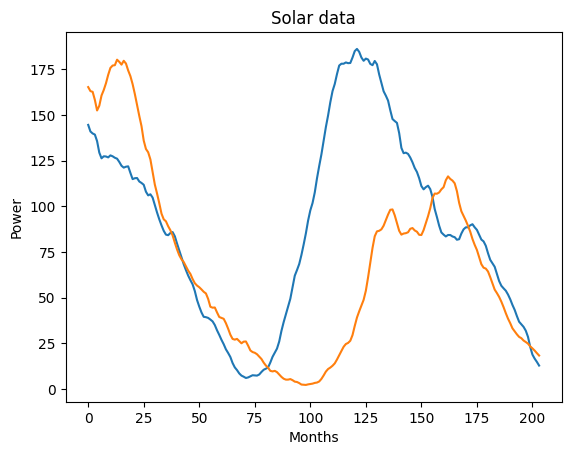

149
0.006711409395973154


In [110]:
# Write your own code below
plt.plot(dataold)
plt.plot(datanew)
plt.xlabel("Months")
plt.ylabel("Power")
plt.title("Solar data");
plt.show()

len(dataold) == 17*12 and len(datanew) == 17*12 # verify data


# ugly solution, just split orange line in half and take largest value
max1 = np.argmax(datanew[:70])
max2 = np.argmax(datanew[70:])

max2 = max2 + 70

print(max2 - max1)

print(1/(max2 - max1))



***Q7. Which are the main oscillation periods of the two data sequences, expressed in months? Also calculate the corresponding frequency value i.e. one over the oscillation period.***

***A7***.

- Main oscillation period: 149 months
- Frequency value: 0.0067 (Hz)

To estimate oscillation period and corresponding frequency directly from data might be tricky as it is difficult to decide where an actual period starts and ends.  Therefore we apply the periodogram and we estimate the oscillation frequency as the frequency value corresponding to the strongest spectral peak.

To avoid falling into tricky Matlab-traps with strange normalization of axes and power values, you are encouraged to code your own periodograms using the following code, where `data` is either `dataold` or `datanew`. The resulting periodogram estimate is presented without power dB-scale and with normalized frequency scale. Zoom in to the range around the approximate frequencies found in Q7.

Text(0.5, 1.0, 'Periodogram')

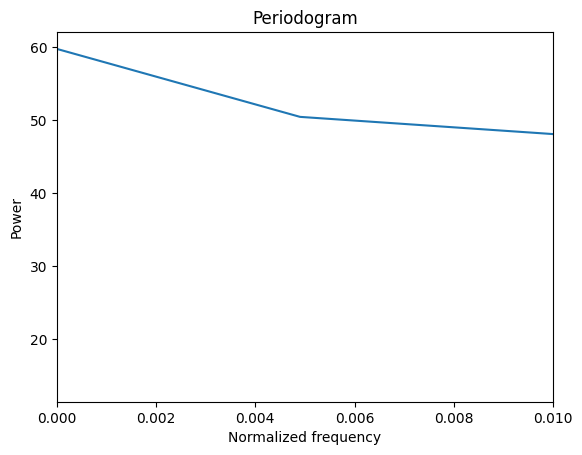

In [157]:
# Write your own code below:
data = datanew # - np.mean(datanew)

# Periodogram
N = len(data)
X = fft(data)
Rhat = (X*np.conj(X))/N
f = np.arange(N)/N

# Plotting
#plt.plot(f,Rhat)
plt.plot(f[:N//2], 10*np.log10(Rhat[:N//2]));
plt.xlabel("Normalized frequency")
plt.ylabel("Power")
plt.xlim(0.00, 0.01)
plt.title("Periodogram")

***Q8. Explain and discuss what you see in your periodograms. Where do the strong spectral peaks at frequency zero come from? Do you find spectral peaks at frequencies that correspond to your estimated frequency values in Q7?***

To avoid leakage from the power at frequency zero, which might hide the interesting frequency information, you should compare your estimates with mean value corrected (zero-mean) sequences. Apply your periodogram to the zero-mean sequence, `data0=dataold-np.mean(dataold)`, and then similarly for the mean value corrected `datanew`.

In [ ]:
# Write your own code below

***Q9. What is the difference between the periodograms of the zero-mean signals and the original signals?***
### 2.2 The advantage of zero-padding data

Unfortunately, the resulting frequencies corresponding to the strong peaks in your periodograms will  correspond exactly to either $2/204\approx 0.0098$ or $1/204\approx 0.0049$  where 204 is the lengths of your data sequences. As the spectral estimates are computed for a sparse grid of frequency values, the periodogram will show a strong peak at one of the above frequencies, even if the actual signal frequency is something else.  For short sequences, the  frequency grid is too sparse to give a good estimate of the actual frequency value. To create a more dense grid of possible frequencies, zero-padding is applied. You should code the zero-padded FFT to be used in your periodogram as the following code, with `nfft` chosen as e.g. 2048, 4096 or 8192. Note that the normalizing factor of the spectral estimate should still be the data length `N` and not the FFT-length `nfft`. Apply your code to the zero-mean corrected signals and study and compare the resulting periodograms.

In [ ]:
# Write your own code below:

***Q10. What are the frequency estimates of the strongest peaks  in the zero-padded periodograms?  Are the values in concordance with your estimated  periods from the sequence plots given in Q7?***

## 3 Spectral analysis of neural oscillations

The measurements of the electrical signals using electrodes on the scalp are called ElectroEncephaloGram (EEG)  and are often clinically used for
detection of tumors, damage, inflammation, stroke and sleep disorders.  In general, the EEG signal is a non-stationary process, but for shorter periods
(1-2 seconds), the EEG activity can be assumed to be stationary. In this exercise we will  examine EEG signals measured during experiments with flickering light.  A flickering light  is sometimes used as stimulus to trigger a seizure for diagnosis and localization of photosensitive epilepsy. Also for a person without epilepsy, the response of such a stimulus is strong, shown as a periodic variation (fundamental tone and harmonics) of the same frequency as the flickering light.

### 3.1 Estimation of an unknown flickering light frequency

In `eegsingle`, such a flickering light trigger has been used as stimulus and the resulting measurement is found in the variable `eegsingle`.  We are also given the information that the flickering light was present only in the middle part of the measured sequence. The time scale of the samples is given in the variable `time_single`.

In [ ]:
# Write your own code below

***Q11. What sampling frequency has been used in the measurement?***

Apply the periodogram, similar as in the previous exercise and study the resulting figure. To be able to identify the response at the actual frequency, specify the frequency scale to be in Hz. Don't forget to adjust the sequence to have zero-mean!

In [ ]:
# Write your own code below:

***Q12. The flickering light frequency should show up as a fundamental tone in the EEG. Can you determine this frequency?***

To estimate the flickering light frequency from the EEG also in this case where we have a very strong stimulus which gives a visible response in the EEG. Most stimulus give a much weaker response in the EEG. As we know that the flickering light is not present in the whole sequence it is wise to use the spectrogram instead of the periodogram.  Apply a spectrogram by using the function `scipy.signal.spectrogram(x,fs=?, noverlap=?, window='hann', nperseg=?,nfft=?)` and view the resulting plot. Change the input variables window length, overlap and number of frequency values `NFFT`  for a better view.


In [ ]:
# Write your own code below

***Q13. Can you determine the frequency of the flickering light, which we know is present as stimulus for some seconds  in the middle of the sequence?***

### 3.2 Multitaper spectral estimation of EEG
Next, `eegmulti` which contains about 5 s of a multi-channel EEG measured according to the 10-20 system, see Figure below, stored in the variable `eegmat`. The time scale of the samples are given in the variable `time_multi`. Check the time scale and compute the sampling frequency.

The 19 channel measurements are ordered as column vectors according to the order in the variable `channels`. The channel order is also presented here in the order of the corresponding column vector in the data matrix: Fp1(0) Fp2(1) F3(2) F4(3) C3(4) C4(5) P3(6) P4(7) O1(8) O2(9) F7(10) F8(11) T3(12) T4(13) T5(14) T6(15) Fz(16) Cz(17) Pz(18). (The positions A1 and A2 are not used in this measurement setup.) A flickering light trigger of 15 Hz has been used as stimulus during all 5 seconds. As the stimulus is visual, we can expect the strongest response in the channels close to the visual centre in the Occipital lobe  (O1 and O2).

Figure: Channel locations, [en.wikipedia.org/wiki/10–20 system (EEG)]

<img src="https://github.com/axellangenskiold/fmsf10/blob/main/Int10-20.png?raw=1" width="300">

Plot the data and make sure you can pick out a single channel as a column vector from the data matrix.   Then adjust each data vector  to have zero-mean! Apply the Welch method using the window length `L=256` of the time-shifted Hanning window, and  use default window overlap 50\%, similar as in section~1, to visualize the 15 Hz response. Calculate the number of windows of your Welch method estimator. **Note that the number of windows has to be an integer, to be chosen so all the applied windows really cover a complete data sequence!**


***Q14.  Sketch and explain how you find the number of windows.***

 Plot a Welch method periodogram of a channel where you can see the 15 Hz frequency (it is not clearly visible in all channels). Here, plot in log-scale.


In [ ]:
# Write your own code below

***Q15. Can you see any additional strong frequencies?***

The Thomson multitaper method give similar results as the Welch method but uses the information in data in a more clever way. The number of applied multitapers are K=2NW-1, where the time-bandwidth product NW is specified as input of the function `calculate_pmtm`. Choose K to be the same number of tapers as for the number of windows of the Welch method above, and compute the corresponding NW. Use this value and compute the Thomson multitaper spectrum as `P = calculate_pmtm(data0,NFFT,NW)`, where data0 is a chosen channel (column vector) from the matrix eegmat which has been corrected to zero-mean.

In [ ]:
# Write your own code below

***Q16. Which method gives the best visual picture of the 15 Hz response?***

***Q17. Assuming that both the Welch estimator and the Thomson estimator are based on averaged sub-spectra that are uncorrelated, which of the two methods will have the smallest variance in your examples above?***

### 3.3 Coherence and correlation of multi-channel EEG

EEG measured from the scalp suffer from strong correlation for closely spaced channels. If the electrodes are placed at a larger distance from each other, the more uncorrelated are the measurements expected to be. In this exercise you will verify that this is true from the previous experiment using  some available spectral methods and statistical tools.

Choose the channel O2 as the reference channel. Measure the (Euclidean) distance between channel O2 and all other channels directly from the figure showing channel positions. The exact measurement values are not of interest, so e.g. rescaling the figure on a screen is not a problem. Order your distance values in a vector according to the given channel order above. Include channel O2 as the distance zero.



***Q18. If you consider that the measurements are performed from a real world 3-dimensional head, what are the possible errors of estimating the distance between channels from the figure given?***

To measure the correlation of two channels, we apply the magnitude squared coherence defined as $\kappa^2(f)=\frac{|\hat R_{xy}(f)|^2}{\hat R_x(f)\hat R_y(f)}$. The advantage of using the coherence in comparison to the more commonly applied time-based correlation, is the possibility to limit the correlation measure to a certain frequency interval, that is of specific interest. In the following, we will extract a frequency interval around 15 Hz and estimate the average coherence in the interval.

You can use the built-in function `scipy.signal.coherence` which automatically computes the coherence function with use of the Welch method cross- and auto-spectra,
`f, kappa2 = scipy.signal.coherence(data0[:,ch1], data0[:,ch2], fs=fs, window='hann', nperseg=?, noverlap=?, nfft=?, axis=-1)`, where `data0[:,ch1]` and  `data0[:,ch2]` are two  zero-mean data sequences representing channel \verb+ch1+ and \verb+ch2+. Plot a few examples of the  magnitude squared coherence for different channel pairs, `plt.plot(f,kappa2)`. You should see the strongest coherence around 15 Hz compared to surrounding frequencies,  for most of the channel pairs.


In [ ]:
#  Write your own code below

***Q19. Decide the frequency interval, including 15 Hz, which shows a strong coherence.***

Find the corresponding indices of this frequency interval in the coherence (most easily the indices are extracted from the frequency output vector `f`).

Calculate the average of the coherence over these indices  and store the  averages in a vector **in the same order as the channel data specified above**. Include the coherence for channel O2 with itself (should be one for all frequencies!).

Plot the distance vector and the average coherence vector in the same plot and study the result. You need to normalize the two vectors to a similar range (e.g. normalize all your values in the distance with the maximum distance) to be able to see something of interest. Finally, compute the (Pearson's r) correlation coefficient between the two vectors using `scipy.stats.pearsonr(x,y)`.

In [ ]:
# Write your own code below

***Q20. Are the two vectors correlated? What is the correlation coefficient value? Is this in accordance with your expectations? Explain why!***